In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
import os
import seaborn as sns

In [2]:
df = pd.read_csv("mean.csv")
df

,AUC,ExecutionTime,seed,fraction,drops,noise,Runs,Model,useclass
0,0.910,0.036,42,1.00,0,0.0,20,LogisticRegression,True
1,0.910,0.031,42,1.00,1,0.0,20,LogisticRegression,True
2,0.910,0.041,42,1.00,2,0.0,20,LogisticRegression,True
3,0.910,0.029,42,1.00,3,0.0,20,LogisticRegression,True
4,0.910,0.031,42,1.00,4,0.0,20,LogisticRegression,True
...,...,...,...,...,...,...,...,...,...
2515,0.502,1.021,314,0.25,0,3.0,20,SVM,True
2516,0.498,0.934,314,0.25,1,3.0,20,SVM,True
2517,0.481,0.995,314,0.25,2,3.0,20,SVM,True
2518,0.536,0.873,314,0.25,3,3.0,20,SVM,True


In [3]:
agg_df = df.drop(['Runs', 'useclass'], axis=1).groupby(['fraction','drops','noise','Model']).mean()
agg_df.drop('seed', axis=1, inplace=True)
agg_df

AUC  ExecutionTime
fraction drops noise Model                                      
0.25     0     0.0   AdaBoost            0.909833       0.179167
                     Decision Tree       0.739167       0.015667
                     GradientBoosting    0.908667       0.323167
                     LogisticRegression  0.896167       0.017667
                     NeuralNetwork       0.908833       2.430167
...                                           ...            ...
1.00     4     3.0   GradientBoosting    0.682667       0.567667
                     LogisticRegression  0.684333       0.029667
                     NeuralNetwork       0.684333       2.544667
                     RandomForest        0.683333       0.475167
                     SVM                 0.499333      13.041667

[420 rows x 2 columns]

In [4]:
resultsdf = agg_df.T.melt(ignore_index=False)
auc_df = resultsdf[resultsdf.index == 'AUC']
auc_df = auc_df.reset_index().drop('index', axis=1)
auc_df = auc_df.round(3)
auc_df.rename(columns={'value': 'auc'}, inplace=True)
auc_df

,fraction,drops,noise,Model,auc
0,0.25,0,0.0,AdaBoost,0.910
1,0.25,0,0.0,Decision Tree,0.739
2,0.25,0,0.0,GradientBoosting,0.909
3,0.25,0,0.0,LogisticRegression,0.896
4,0.25,0,0.0,NeuralNetwork,0.909
...,...,...,...,...,...
415,1.00,4,3.0,GradientBoosting,0.683
416,1.00,4,3.0,LogisticRegression,0.684
417,1.00,4,3.0,NeuralNetwork,0.684
418,1.00,4,3.0,RandomForest,0.683


In [21]:
resultsdf = agg_df.T.melt(ignore_index=False)
time_df = resultsdf[resultsdf.index == 'ExecutionTime']
time_df = time_df.reset_index().drop('index', axis=1)
time_df = time_df.round(3)
time_df.rename(columns={'value': 'time'}, inplace=True)
df_time = time_df.copy()

In [22]:
df = pd.concat([auc_df, time_df['time']], axis=1)
df = df.query("noise == 0")
df = df.set_index(['fraction', 'drops', 'noise', 'Model']	)
df

auc    time
fraction drops noise Model                            
0.25     0     0.0   AdaBoost            0.910   0.179
                     Decision Tree       0.739   0.016
                     GradientBoosting    0.909   0.323
                     LogisticRegression  0.896   0.018
                     NeuralNetwork       0.909   2.430
...                                        ...     ...
1.00     4     0.0   GradientBoosting    0.911   0.728
                     LogisticRegression  0.903   0.030
                     NeuralNetwork       0.912   4.855
                     RandomForest        0.886   0.797
                     SVM                 0.695  16.227

[105 rows x 2 columns]

local results

In [36]:
df_auc = df.drop(['time'], axis=1).unstack(level=3)
loss_auc = df_auc.loc[(1,0,0)] - df_auc
loss_auc = loss_auc.round(3).droplevel(2)
loss_auc = loss_auc.T.droplevel(0).T
loss_auc = loss_auc.melt(value_name='loss_auc', ignore_index=False).reset_index()
df_auc = df_auc.droplevel(2).T.droplevel(0).T.melt(value_name='auc', ignore_index=False).reset_index()
loss_auc

,fraction,drops,Model,loss_auc
0,0.25,0,AdaBoost,0.002
1,0.25,1,AdaBoost,0.002
2,0.25,2,AdaBoost,0.003
3,0.25,3,AdaBoost,0.002
4,0.25,4,AdaBoost,0.002
...,...,...,...,...
100,1.00,0,SVM,0.000
101,1.00,1,SVM,0.019
102,1.00,2,SVM,0.003
103,1.00,3,SVM,0.028


In [30]:
df_time = df.drop(['auc'], axis=1).unstack(level=3)
speedup_df = df_time.loc[(1,0,0)]/df_time
speedup_df = speedup_df.round(3).droplevel(2)
speedup_df = speedup_df.T.droplevel(0).T
speedup_df = speedup_df.melt(value_name='speedup', ignore_index=False).reset_index()
df_time = df_time.droplevel(2).T.droplevel(0).T.melt(value_name='time', ignore_index=False).reset_index()
speedup_df

,fraction,drops,Model,speedup
0,0.25,0,AdaBoost,2.101
1,0.25,1,AdaBoost,2.173
2,0.25,2,AdaBoost,2.161
3,0.25,3,AdaBoost,2.238
4,0.25,4,AdaBoost,2.279
...,...,...,...,...
100,1.00,0,SVM,1.000
101,1.00,1,SVM,1.066
102,1.00,2,SVM,1.101
103,1.00,3,SVM,1.100


In [34]:
pd.concat([speedup_df, df_time.time], axis=1)

,fraction,drops,Model,speedup,time
0,0.25,0,AdaBoost,2.101,0.179
1,0.25,1,AdaBoost,2.173,0.173
2,0.25,2,AdaBoost,2.161,0.174
3,0.25,3,AdaBoost,2.238,0.168
4,0.25,4,AdaBoost,2.279,0.165
...,...,...,...,...,...
100,1.00,0,SVM,1.000,19.561
101,1.00,1,SVM,1.066,18.354
102,1.00,2,SVM,1.101,17.761
103,1.00,3,SVM,1.100,17.788


In [38]:
data = pd.concat([speedup_df, df_auc.auc, df_time.time, loss_auc.loss_auc], axis=1)#.query('speedup == 1 and loss_auc==0 ')
data

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0,AdaBoost,2.101,0.910,0.179,0.002
1,0.25,1,AdaBoost,2.173,0.910,0.173,0.002
2,0.25,2,AdaBoost,2.161,0.909,0.174,0.003
3,0.25,3,AdaBoost,2.238,0.910,0.168,0.002
4,0.25,4,AdaBoost,2.279,0.910,0.165,0.002
...,...,...,...,...,...,...,...
100,1.00,0,SVM,1.000,0.683,19.561,0.000
101,1.00,1,SVM,1.066,0.664,18.354,0.019
102,1.00,2,SVM,1.101,0.680,17.761,0.003
103,1.00,3,SVM,1.100,0.655,17.788,0.028


In [39]:
data.query("drops == 0")

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0,AdaBoost,2.101,0.910,0.179,0.002
5,0.50,0,AdaBoost,1.560,0.911,0.241,0.001
10,1.00,0,AdaBoost,1.000,0.912,0.376,0.000
15,0.25,0,Decision Tree,1.938,0.739,0.016,0.055
20,0.50,0,Decision Tree,1.409,0.767,0.022,0.027
25,1.00,0,Decision Tree,1.000,0.794,0.031,0.000
30,0.25,0,GradientBoosting,2.793,0.909,0.323,0.002
35,0.50,0,GradientBoosting,1.745,0.910,0.517,0.001
40,1.00,0,GradientBoosting,1.000,0.911,0.902,0.000
45,0.25,0,LogisticRegression,1.778,0.896,0.018,0.008


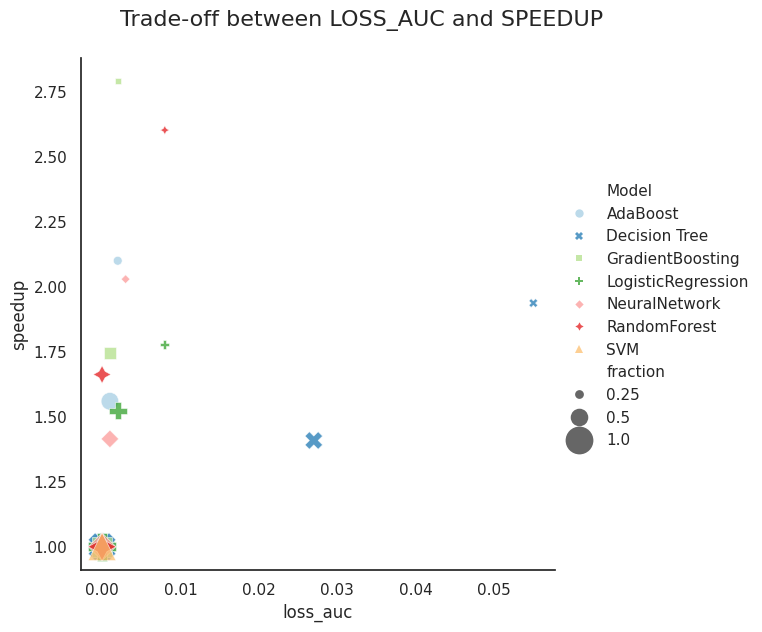

In [51]:
from matplotlib.ticker import MaxNLocator
sns.set_theme(style="white")

xc = "loss_auc"
yc = "speedup"

# Create the plot
g = sns.relplot(
    x=xc, y=yc, hue="Model", size="fraction",
    sizes=(40, 400), alpha=.75, palette='Paired',
    style='Model',
    height=6, data=data.query("drops == 0 and speedup<=4")
)

# Definir título principal para o gráfico inteiro
titulo = f"Trade-off between {xc.upper()} and {yc.upper()}"
g.fig.suptitle(titulo, y=1.05, fontsize=16)


plt.savefig(f'{titulo}.png', dpi=400, bbox_inches="tight")

In [52]:
data

,fraction,drops,Model,speedup,auc,time,loss_auc
0,0.25,0.0,AdaBoost,2.101,0.910,0.179,0.002
1,0.25,1.0,AdaBoost,2.173,0.739,0.016,0.002
2,0.25,2.0,AdaBoost,2.161,0.909,0.323,0.003
3,0.25,3.0,AdaBoost,2.238,0.896,0.018,0.002
4,0.25,4.0,AdaBoost,2.279,0.909,2.430,0.002
...,...,...,...,...,...,...,...
100,1.00,0.0,SVM,1.000,0.678,0.237,0.000
101,1.00,1.0,SVM,1.066,0.684,0.016,0.019
102,1.00,2.0,SVM,1.101,0.684,1.574,0.003
103,1.00,3.0,SVM,1.100,0.678,0.237,0.028


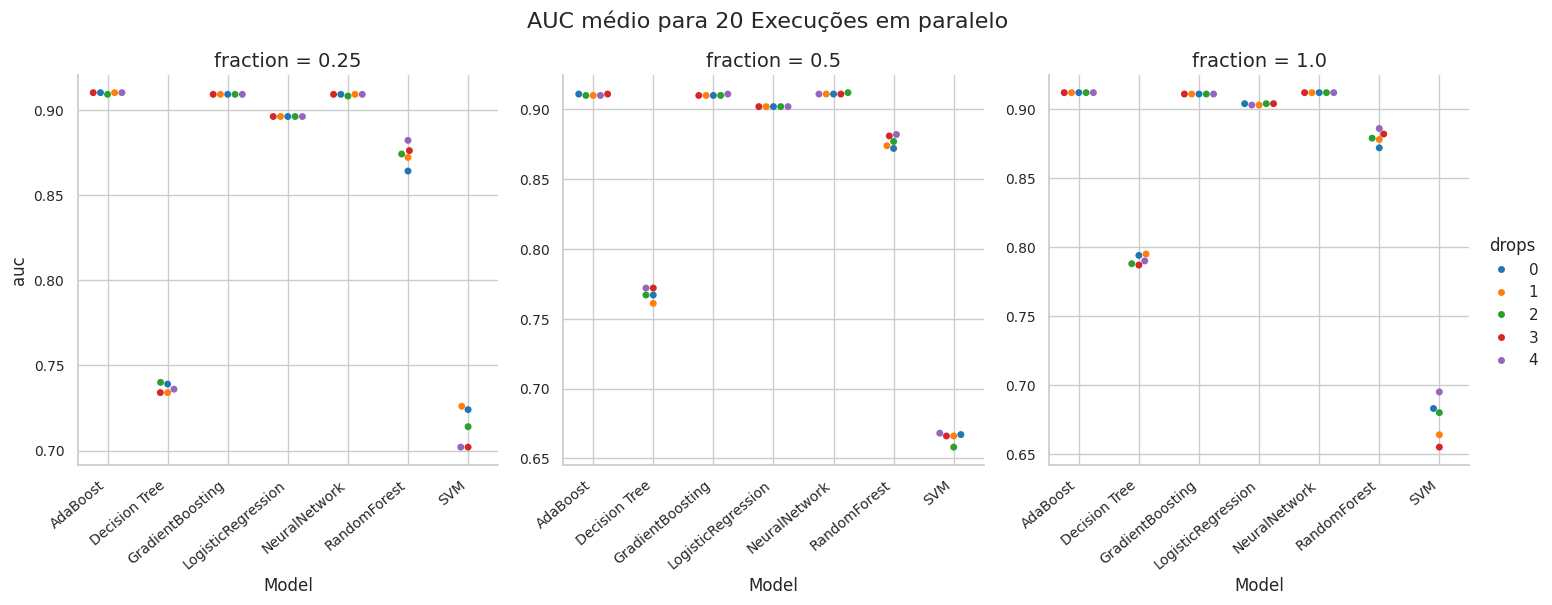

In [44]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc = "Model"
yc = "auc"
g = sns.catplot(
    data=data, 
    x=xc, 
    y=yc, 
    hue="drops",
    col="fraction", 
    kind="swarm", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções em paralelo"
g.fig.suptitle(titulo, y=1.05, fontsize=16)


# Aumentar o tamanho dos ticks dos eixos e rotacionar as labels
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines
    # Define the ticks explicitly
    ax.set_xticks(ax.get_xticks())
    # Rotacionar as labels do eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)


# plt.tight_layout()
plt.savefig(f'{titulo}.png', dpi=400, bbox_inches="tight")

In [45]:
df = pd.read_csv(filepath_or_buffer="RF.csv")
df

,Model,AUC,ExecutionTime,seed,fraction,drops,useclass,noise,n_jobs
0,RandomForest,0.886,5.998,1,1.000,0,True,0,1
1,RandomForest,0.883,3.682,1,1.000,0,True,0,2
2,RandomForest,0.890,2.666,1,1.000,0,True,0,4
3,RandomForest,0.882,4.119,1,1.000,0,True,0,8
4,RandomForest,0.884,4.850,1,1.000,0,True,0,16
...,...,...,...,...,...,...,...,...,...
975,RandomForest,0.889,3.259,20,0.016,0,True,0,4
976,RandomForest,0.874,3.265,20,0.016,0,True,0,8
977,RandomForest,0.889,3.309,20,0.016,0,True,0,16
978,RandomForest,0.894,3.009,20,0.016,0,True,0,32


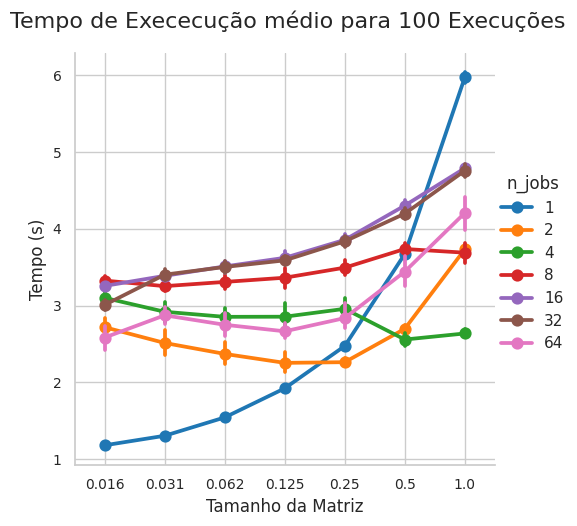

In [46]:

# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")

g = sns.catplot(
    data=df,
    x="fraction", 
    y="ExecutionTime", 
    hue="n_jobs", 
    kind="point", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = "Tempo de Exececução médio para 100 Execuções"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
g.set_axis_labels("Tamanho da Matriz", "Tempo (s)", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400)

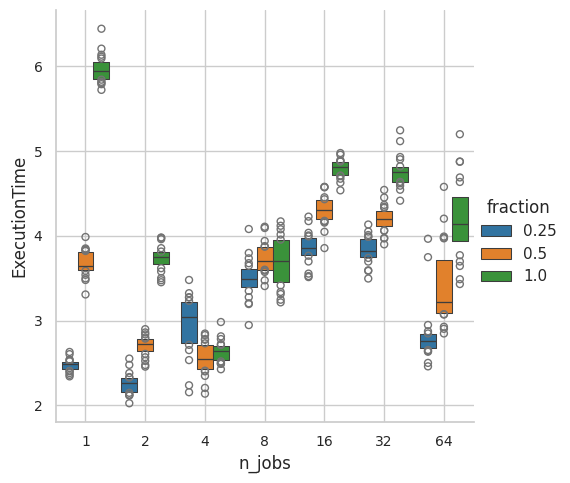

In [47]:

# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")

g = sns.catplot(
    data=df.query("fraction >=0.25"),
    x="n_jobs", 
    y="ExecutionTime", 
    hue="fraction", 
    kind="boxen", 
    sharey=False, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# # Definir título principal para o gráfico inteiro
# titulo = "Tempo de Exececução médio para 100 Execuções"
# g.fig.suptitle(titulo, y=1.05, fontsize=16)

# # Definir rótulos dos eixos para cada eixo individual
# g.set_axis_labels("Tamanho da Matriz", "Tempo (s)", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400)

In [48]:
df_auc = df.drop(['ExecutionTime', "Model", "drops", "noise", "useclass"], axis=1).query("n_jobs == 1")
df_auc = df_auc.pivot(index=['fraction'],columns=['seed'], values='AUC')
loss_df = df_auc.loc[(1)] - df_auc
loss_df = loss_df.round(3)
loss_df = loss_df.melt(value_name='auc_loss', ignore_index=False).reset_index()
loss_df

,fraction,seed,auc_loss
0,0.016,1,0.005
1,0.031,1,-0.007
2,0.062,1,0.006
3,0.125,1,-0.005
4,0.250,1,-0.002
...,...,...,...
135,0.062,20,-0.028
136,0.125,20,-0.017
137,0.250,20,-0.020
138,0.500,20,0.005


In [51]:
df_time.melt(value_name='speedup', ignore_index=False).reset_index()

,n_jobs,fraction,seed,speedup
0,1,0.016,1,1.188
1,1,0.031,1,1.313
2,1,0.062,1,1.499
3,1,0.125,1,2.033
4,1,0.250,1,2.499
...,...,...,...,...
975,64,0.062,20,2.282
976,64,0.125,20,2.770
977,64,0.250,20,2.634
978,64,0.500,20,3.971


In [49]:
df_time = df.drop(['AUC', "Model", "drops", "noise", "useclass"], axis=1)#.unstack(level=3)
df_time = df_time.pivot(index=['n_jobs', 'fraction'],columns='seed', values='ExecutionTime')

speedup_df = df_time.loc[(1,1)]/df_time
speedup_df = speedup_df.round(3)

speedup_df = speedup_df.melt(value_name='speedup', ignore_index=False).reset_index()
# speedup_df = speedup_df.drop('index', axis=1)
speedup_df['efficiency'] = speedup_df.speedup/speedup_df.n_jobs
speedup_df['time'] = df_time.melt(ignore_index=False).reset_index()["value"]
speedup_df

,n_jobs,fraction,seed,speedup,efficiency,time
0,1,0.016,1,5.049,5.049000,1.188
1,1,0.031,1,4.568,4.568000,1.313
2,1,0.062,1,4.001,4.001000,1.499
3,1,0.125,1,2.950,2.950000,2.033
4,1,0.250,1,2.400,2.400000,2.499
...,...,...,...,...,...,...
975,64,0.062,20,2.549,0.039828,2.282
976,64,0.125,20,2.100,0.032813,2.770
977,64,0.250,20,2.208,0.034500,2.634
978,64,0.500,20,1.465,0.022891,3.971


In [62]:
speedup_df.query("fraction >= 0.5").groupby(['n_jobs',	'fraction']).mean()

seed  speedup  efficiency     time
n_jobs fraction                                    
1      0.5       10.5  1.62865    1.628650  3.67310
       1.0       10.5  1.00000    1.000000  5.97460
2      0.5       10.5  2.21725    1.108625  2.69840
       1.0       10.5  1.60165    0.800825  3.73400
4      0.5       10.5  2.35115    0.587787  2.55835
       1.0       10.5  2.26925    0.567312  2.63745
8      0.5       10.5  1.60285    0.200356  3.73825
       1.0       10.5  1.63025    0.203781  3.69000
16     0.5       10.5  1.39020    0.086888  4.30375
       1.0       10.5  1.24775    0.077984  4.79090
32     0.5       10.5  1.42515    0.044536  4.19890
       1.0       10.5  1.25770    0.039303  4.75835
64     0.5       10.5  1.76395    0.027562  3.44350
       1.0       10.5  1.43730    0.022458  4.20775

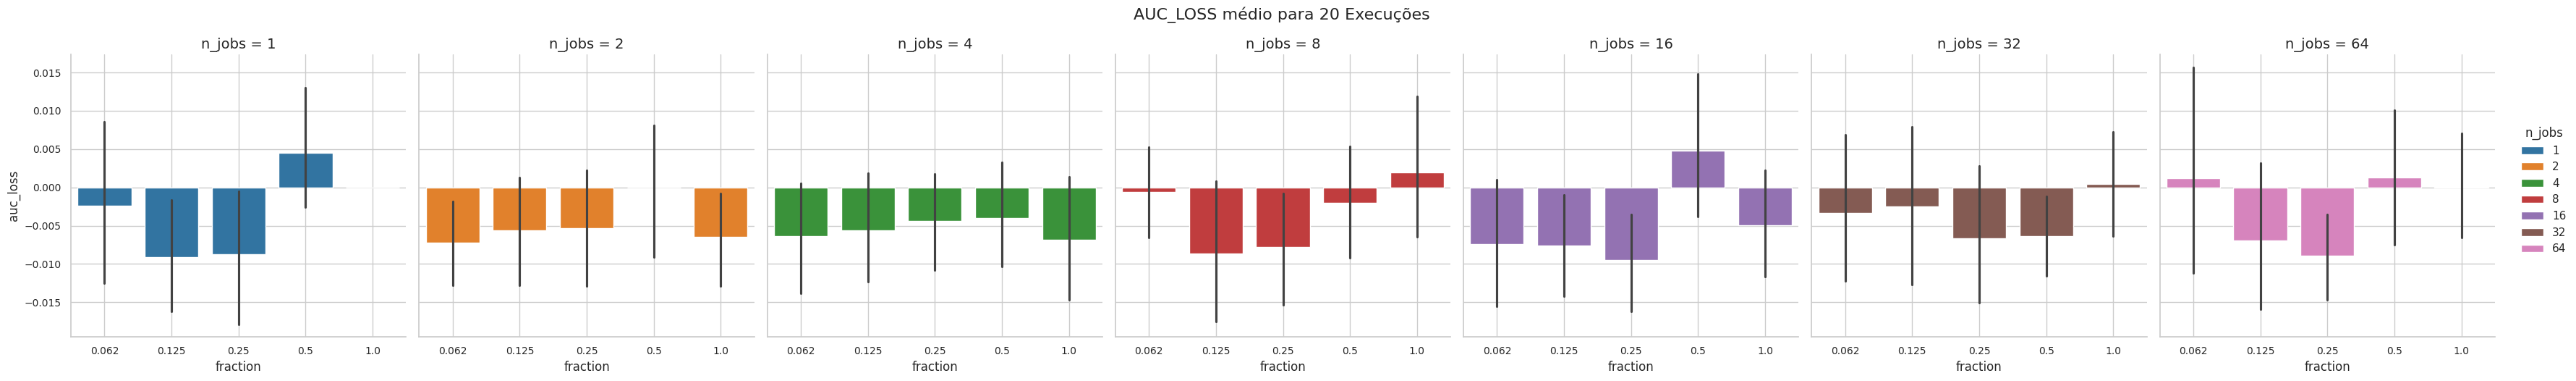

In [39]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc="fraction"
yc="speedup"
g = sns.catplot(
    data=speedup_df.query("fraction >=0.06"),
    x=xc, 
    y=yc, 
    hue="n_jobs", 
    kind="bar",
    col="n_jobs", 
    sharey=True, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
g.set_axis_labels(x_var=f"{xc}", f"{yc}", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

# plt.savefig(f'{titulo}.png', dpi=400,bbox_inches="tight")

In [78]:
df_loss_auc = pd.concat([speedup_df.query("n_jobs == 1").reset_index().drop('index', axis=1), loss_df['auc_loss']], axis=1)
df_loss_auc.drop("n_jobs", axis=1, inplace=True)
df_loss_auc

,fraction,seed,speedup,efficiency,time,auc_loss
0,0.016,1,5.049,5.049,1.188,0.005
1,0.031,1,4.568,4.568,1.313,-0.007
2,0.062,1,4.001,4.001,1.499,0.006
3,0.125,1,2.950,2.950,2.033,-0.005
4,0.250,1,2.400,2.400,2.499,-0.002
...,...,...,...,...,...,...
135,0.062,20,3.965,3.965,1.467,-0.028
136,0.125,20,3.091,3.091,1.882,-0.017
137,0.250,20,2.420,2.420,2.404,-0.020
138,0.500,20,1.622,1.622,3.587,0.005


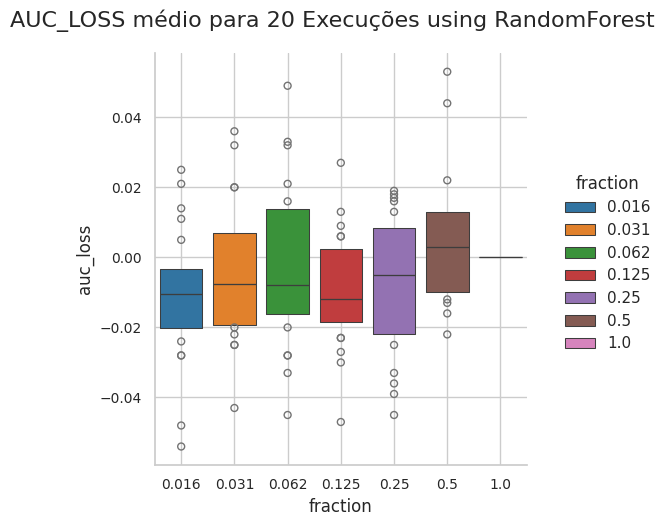

In [87]:
# Configurar o tema
sns.set_theme(style="whitegrid", palette="tab10")
xc="fraction"
yc="auc_loss"
g = sns.catplot(
    data=df_loss_auc.query("fraction >=0.0"),
    x=xc, 
    y=yc, 
    hue="fraction", 
    kind="boxen",
    # col="n_jobs", 
    sharey=True, 
    sharex=False, 
    legend=True,  
    log_scale=False,
    palette="tab10",
)

# Definir título principal para o gráfico inteiro
titulo = f"{yc.upper()} médio para 20 Execuções using RandomForest"
g.fig.suptitle(titulo, y=1.05, fontsize=16)

# Definir rótulos dos eixos para cada eixo individual
# g.set_axis_labels(x_var=f"{xc}", f"{yc}", fontsize=12)

# Aumentar o tamanho dos ticks dos eixos
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=10)  # Ajustar o tamanho da fonte dos ticks
    ax.grid(True)  # Adicionar gridlines

# Definir título para cada gráfico de coluna
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=14)

plt.savefig(f'{titulo}.png', dpi=400,bbox_inches="tight")